In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Import/Fetch the Dataset


Source: https://archive.ics.uci.edu/ml/datasets/Forest+Fires

In [ ]:
dataset_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv'
forest_df = pd.read_csv(dataset_url)

Let's see the features and their data types

In [ ]:
forest_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [ ]:
forest_df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


The dataset contains 517 examples and 13 columns, 12 features and 1 label (areas).

In [ ]:
print(forest_df.shape)

(517, 13)


## Split the dataset
We will not go deep into analysis, but let's try to learn about the data we have. Before that, we will first split the dataset into training and test set.

We will use Scikit-Learn train_test_split.



In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(forest_df, test_size=0.2, random_state=42)

In [ ]:
print('The shape of training data: {}\nThe shape of testing data: {}'.format(train_data.shape, test_data.shape))

The shape of training data: (413, 13)
The shape of testing data: (104, 13)


In [ ]:
train_data.head(5)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
329,4,3,sep,sat,92.2,102.3,751.5,8.4,23.5,27,4.0,0.0,3.33
173,4,4,sep,mon,90.9,126.5,686.5,7.0,17.7,39,2.2,0.0,3.07
272,2,5,aug,tue,92.1,152.6,658.2,14.3,20.2,47,4.0,0.0,3.09
497,3,4,aug,tue,96.1,181.1,671.2,14.3,32.3,27,2.2,0.0,14.68
182,5,4,feb,sun,86.8,15.6,48.3,3.9,12.4,53,2.2,0.0,6.38


It seems that we have two categorical features, month and day. We will remember to encode them. For now we can see the number of samples in each month and later in each day.

In [ ]:
area_mean = train_data.area.mean()
area_std = train_data.area.std()
print(area_mean, area_std)

normalized_area_column = (train_data.area - area_mean) / area_std

11.132130750605326 45.65854799128173


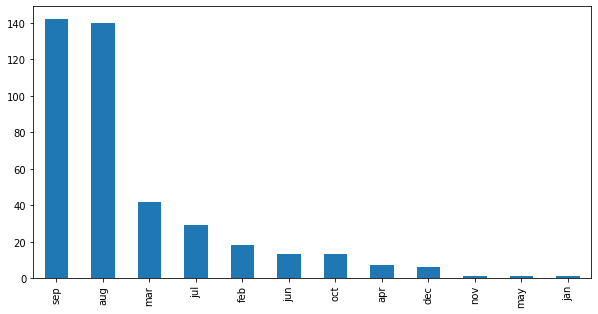

In [ ]:
train_data['month'].value_counts().plot(kind='bar', figsize=(10,5))

# Preparing the Data for the Model
Here we will do two things, 

1. one is to normalize numerical features -> area, ...
2. and the second is to encode categorical features. -> month and day 


We can set up a pipeline to handle that.

For simplicity, we will use Scikit-Learn processing functions.

We will first separate features and label. We can use a function that can also be applied to test set.

In [ ]:
def get_feats_and_labels(data, label):
  """ Take data and label as inputs, return features and labels separated """

  # drop the label column and save it in data_feats variable -> essentially getting everything other than the label column.
  data_feats = data.drop(label, axis=1)

  # labels of the dataset = label column in the dataframe.
  data_label = data[label]

  return data_feats, data_label

Let's use the function created above to get the features and labels.

In [ ]:
train_feats, train_label = get_feats_and_labels(train_data, 'area')

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

scaler = StandardScaler() # normalization engine
encoder = OrdinalEncoder() # encoder engine

# The column transformer requires lists of features

num_feats = ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
cat_feats = ['month', 'day']

# define the pipeline to scale the numeric features and handle categorical features
final_pipe = ColumnTransformer([           
   ('num', scaler, num_feats),  # normalize all numerical feats
   ('cat', encoder, cat_feats),  # encode all categorical feats                      
   # ('xyz', random, some_feats)
])

training_data_prepared = final_pipe.fit_transform(
                                                    train_feats
                                                    )


Now, we can see the shape of the transformed dataset. It is a NumPy array.

In [ ]:
training_data_prepared.shape

(413, 12)

In [ ]:
type(training_data_prepared)

numpy.ndarray

In [ ]:
training_data_prepared.min()

-12.080907025534259

In [ ]:
training_data_prepared.max()

19.84930903705603

In [ ]:
training_data_prepared[1]

array([-0.288472  , -0.26669645,  0.06165224,  0.21786634,  0.54913614,
       -0.45543431, -0.2052724 , -0.33521489, -1.00892252, -0.06781709,
       11.        ,  1.        ])

Also let's tranform the test set. Note that for the test set, we don't fit_transform().

We will get the features and labels separated first.

In [ ]:
test_feats, test_label = get_feats_and_labels(test_data, 'area')

In [ ]:
test_data_prepared = final_pipe.transform(test_feats)

In [ ]:
train_label = train_label.to_numpy()
test_label = test_label.to_numpy()

In [ ]:
train_label[1]

3.07

# Creating, Compiling and Training a Model
Now that our data is prepared, it's time to create a neural network.
Everytime we are creating a model in TensorFlow, we have to specify the input shape. In this example, the input shape will be:

In [ ]:
input_shape = training_data_prepared.shape[1:]
input_shape

(12,)

# Step 3

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(12,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu') #relu activation always pass positive real numbers and returns zero for negative numbers.
])

# Now we compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1664      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 18,305
Trainable params: 18,305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Show your model summary here

# Step 4

In [ ]:
#train your model here
model.fit(x=training_data_prepared,
          y=train_label,
          epochs=500
          )

Epoch 1/500
13/13 [==============================] - 0s 2ms/step - loss: 2155.6150
Epoch 2/500
13/13 [==============================] - 0s 2ms/step - loss: 2112.8560
Epoch 3/500
13/13 [==============================] - 0s 3ms/step - loss: 2103.9863
Epoch 4/500
13/13 [==============================] - 0s 2ms/step - loss: 2087.6606
Epoch 5/500
13/13 [==============================] - 0s 2ms/step - loss: 2075.4851
Epoch 6/500
13/13 [==============================] - 0s 2ms/step - loss: 2065.8865
Epoch 7/500
13/13 [==============================] - 0s 3ms/step - loss: 2050.3379
Epoch 8/500
13/13 [==============================] - 0s 2ms/step - loss: 2039.2924
Epoch 9/500
13/13 [==============================] - 0s 2ms/step - loss: 2025.4836
Epoch 10/500
13/13 [==============================] - 0s 2ms/step - loss: 2017.4481
Epoch 11/500
13/13 [==============================] - 0s 2ms/step - loss: 2006.6451
Epoch 12/500
13/13 [==============================] - 0s 2ms/step - loss: 1995.3398
E

# Evaluating a Model
After we have trained the model, the next step is to evaluate it.

In [ ]:
#To evaluate the model, run this cell
model.evaluate(test_data_prepared, test_label) # OVERFITTING -> DROPOUT.

4/4 [==============================] - 0s 3ms/step - loss: 13371.1807


13371.1806640625

#Bonus: Improving the model

In [ ]:
#Can you improve the model? 